# EnvErgo project
- [researchgate link](https://www.researchgate.net/project/Isokinetic-measurements-and-musculoskeletal-modelling-for-ergonomics)
- [github link](https://github.com/romainmartinez/envergo)

_Romain Martinez_

# Anthropometry Analysis

In [1]:
# libraries
import envergo  # local functions (see mvc/ folder)
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="ticks")

In [2]:
df = pd.read_excel('./data/Anthropo_MTL.xlsx').dropna()
# set participant pseudo as index
df.set_index('Subject', inplace=True)
# remove unwanted string in Laterality column
df['Laterality'].replace(regex=True, inplace=True, to_replace=r"'", value=r'')
# print head
df.tail()

,Location,Age,Laterality,Height (m),Weight (kg),IMC,PA (h/sem),Trunk_length,Arm_length,Forearm_length,Hand_length,Pelvis_width,Hand_width
Subject,,,,,,,,,,,,,
CHMI29011992,montreal,1992,R,1.710,87.00,29.75,0.5,0.440,0.265,0.23,0.185,0.190,0.0450
BEMI16091980,montreal,1980,L,1.730,87.00,29.06,2.0,0.570,0.280,0.27,0.210,0.185,0.0420
ANMA08101983,montreal,1983,L,1.700,76.00,26.30,1.0,0.490,0.300,0.23,0.170,0.075,0.0110
HAAL30041963,montreal,1963,R,1.708,73.65,25.19,5.0,0.425,0.300,0.24,0.177,0.080,0.0200
CAJU22031991,montreal,1991,R,1.790,96.00,29.96,2.5,0.510,0.330,0.27,0.170,0.115,0.0275


## 1. Normality tests (Shapiro-Wilk test)
- The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.
- It is reputadely more well suited to smaller datasets.
- Reference:

> Shapiro, S. S. & Wilk, M.B (1965). An analysis of variance test
        for normality (complete samples), Biometrika, Vol. 52, pp. 591-611.

In [3]:
def normality_test(data, case='shapiro', group=None, outliers_fct=None):
    """Perform normality test.
    The title color is associated with the p-value of the normality test (either shapiro or kolmogorov-smirnov).

    Args:
        d: pandas dframe
        case: 'shapiro' or 'kolmogorov-smirnov'
        group: pandas series
        outliers: index of outliers

    Returns:
        Dist plot of arrays.
    """
    fig, axs = plt.subplots(2, 6, figsize=(25, 8))
    string_col = data.loc[:, data.dtypes == object]
    

    for ivar, ax in zip(data.drop(string_col.columns, axis=1), axs.ravel()):
        d = data.copy()
        if outliers_fct:
            outliers = d[ivar].loc[is_outlier(d[ivar])]
            if outliers.any():
                d.drop(outliers.index, axis=0, inplace=True)
                print('\n'.join('{}: {} [{}]'.format(ivar, index, value) for index, value in
                                zip(outliers.index.tolist(), outliers.values)))
                ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)
        if case == 'shapiro':
            test = scipy.stats.shapiro(d[ivar])
            sns.distplot(d[ivar], ax=ax, rug=True, hist=False)
        elif case == 'kolmogorov-smirnov':
            lyon = d[d[group] == 'lyon'][ivar]
            montreal = d[d[group] == 'montreal'][ivar]
            test = test = scipy.stats.ks_2samp(lyon, montreal)
            sns.distplot(lyon, ax=ax, rug=True, hist=False)
            sns.distplot(montreal, ax=ax, rug=True, hist=False)
        else:
            raise ValueError('Wrong case')

        ax.set_xlabel('')
        color = 'g' if test[1] > 0.05 else 'r'
        ax.set_title('{}\nTest: {:.3f}\np-value: {:.3f}'.format(ivar, test[0], test[1]), color=color)

    axs[-1, -1].axis('off')  # remove last axis
    fig.tight_layout()
    fig.suptitle('{} test (sample: {}, DoF: {})'.format(case, d[ivar].size, d[ivar].size - 1), y=1.05,
                 fontsize=15)
    sns.despine(offset=10)
    plt.show()

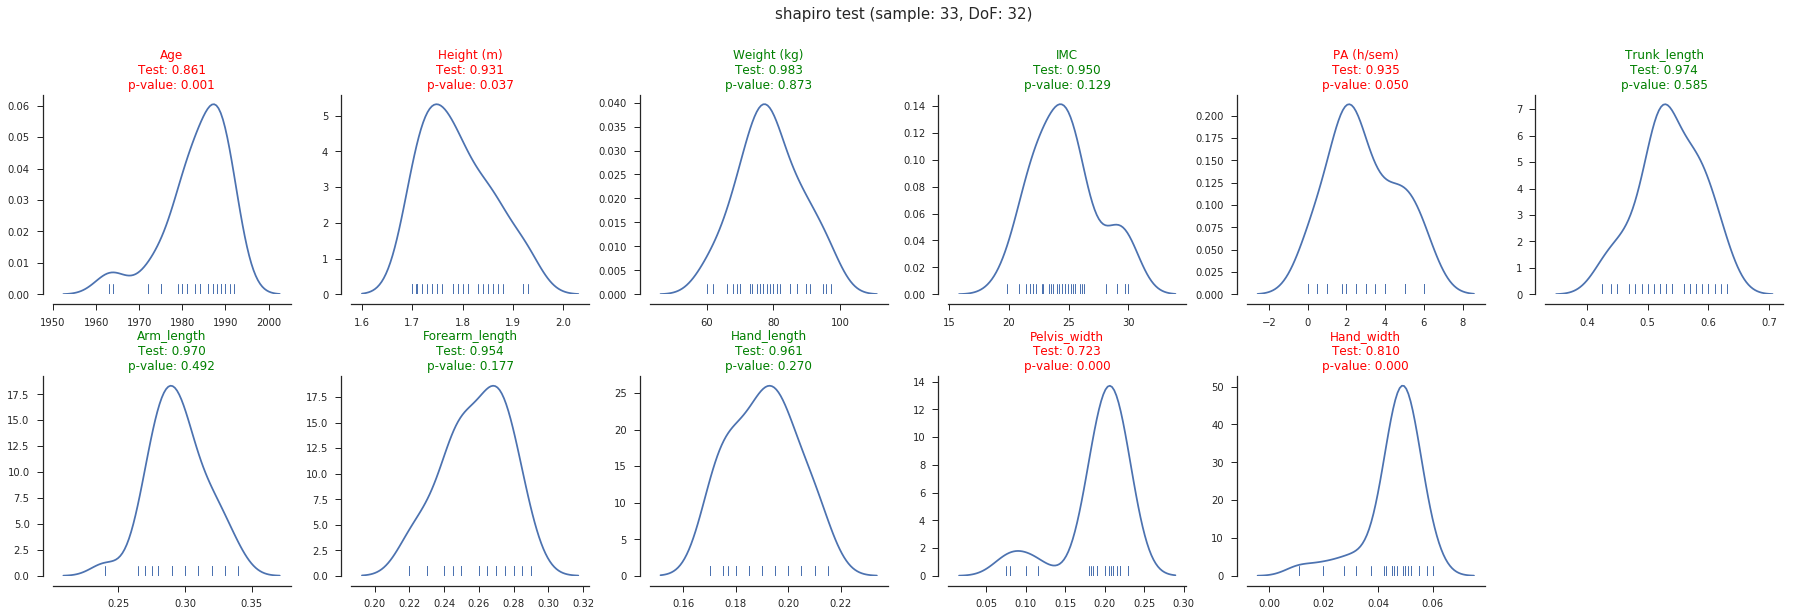

In [4]:
normality_test(df, case='shapiro')

## Outcomes

- variables that don't follow normal distribution: `Age`, `Height`, `PA`, `Pelvis_width` and `Hand_width`

## 2. Are the france-canada groups homogeneous? (Kolmogorov-Smirnov test)
- The Kolmogorov-Smirnov test can be applied more broadly than Shapiro, since it is comparing any two distributions against each other, not necessarily one distriubtion to a normal one.
- Reference:

> Massey Jr, F. J. (1951). The Kolmogorov-Smirnov test for goodness of fit.
        Journal of the American statistical Association, 46(253), 68-78.

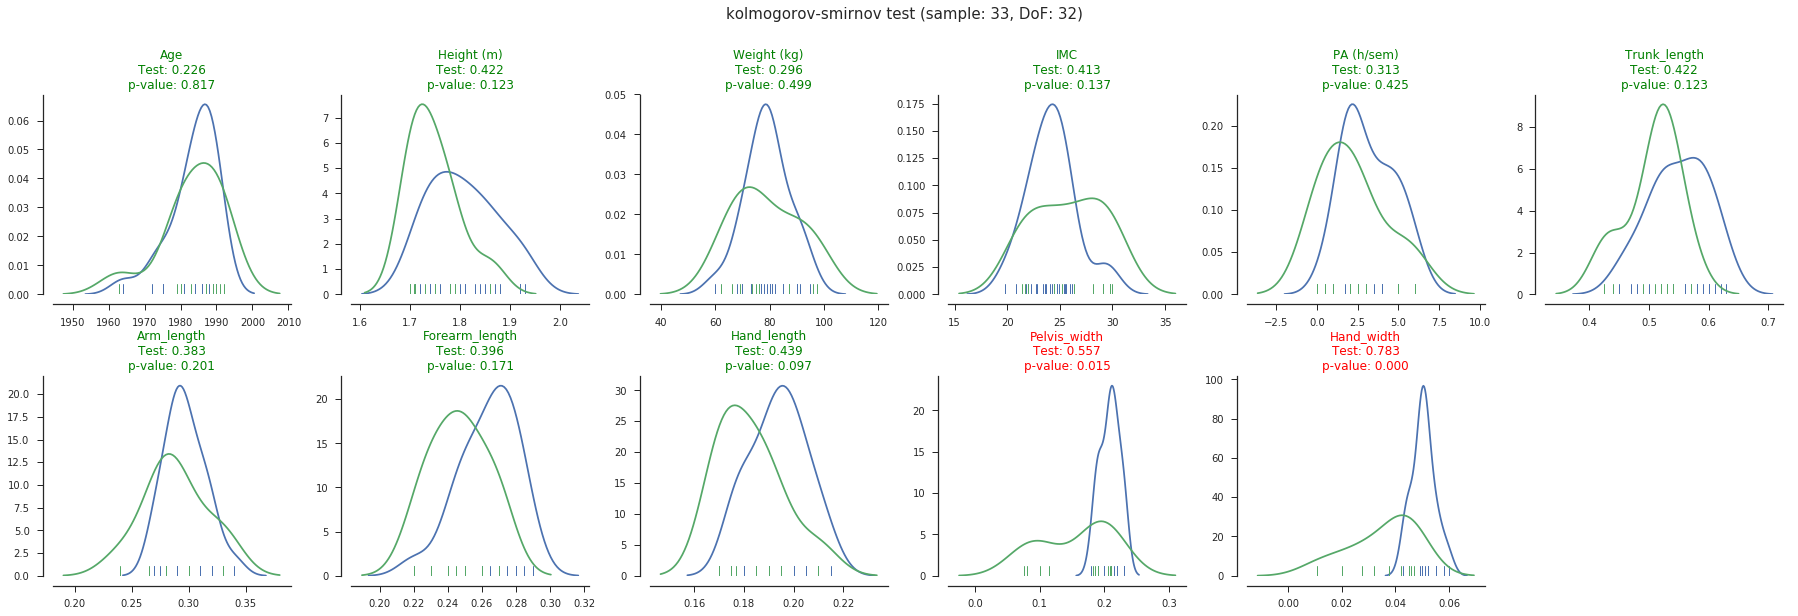

In [5]:
normality_test(df, case='kolmogorov-smirnov', group='Location')

## Outcomes
- The Kolmogorov-Smirnov test reject equal distribution between Montréal and Lyon samples only for the `Pelvis_width` and `Hand_width`
- But, it seems that montreal have some outliers on these two variables

# 3. Outliers
- A common outlier test is based on the percentile
    - but the points identified as outliers is a function of your sample size
- Another outlier test is to remove points based on their "median absolute deviation"
    - this classifier works correctly regardless of sample-size
- Reference:

> Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 

In [6]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

- Let's see if the outliers affect the previous test:

Age: DELA16091964 [1964]
Age: HAAL30041963 [1963]
Pelvis_width: GRFA28041990 [0.1]
Pelvis_width: ANMA08101983 [0.075]
Pelvis_width: HAAL30041963 [0.08]
Hand_width: ANMA08101983 [0.011000000000000001]
Hand_width: HAAL30041963 [0.02]


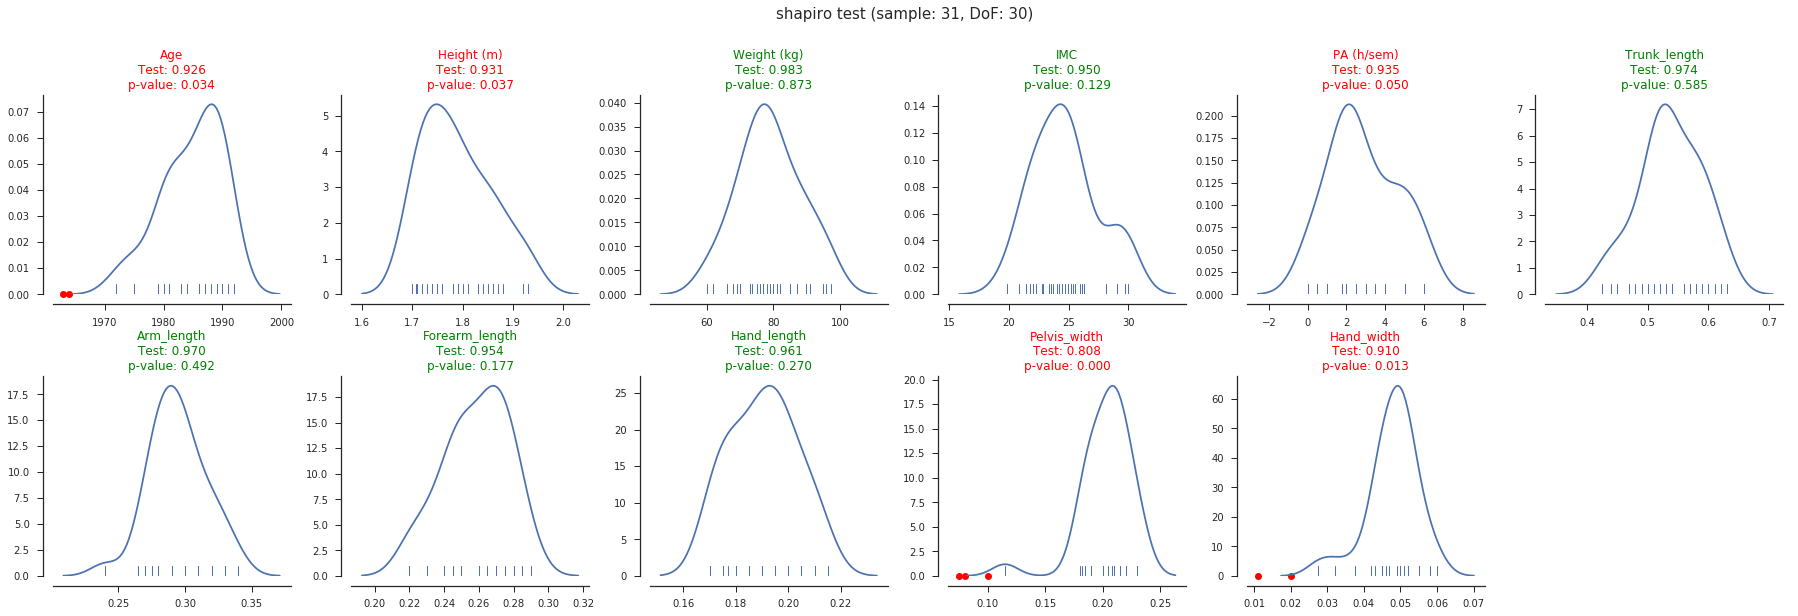

In [7]:
normality_test(df, case='shapiro', outliers_fct=is_outlier)

## Outcomes
- Removing outliers did not modify the Shapiro test outcomes

Age: DELA16091964 [1964]
Age: HAAL30041963 [1963]
Pelvis_width: GRFA28041990 [0.1]
Pelvis_width: ANMA08101983 [0.075]
Pelvis_width: HAAL30041963 [0.08]
Hand_width: ANMA08101983 [0.011000000000000001]
Hand_width: HAAL30041963 [0.02]


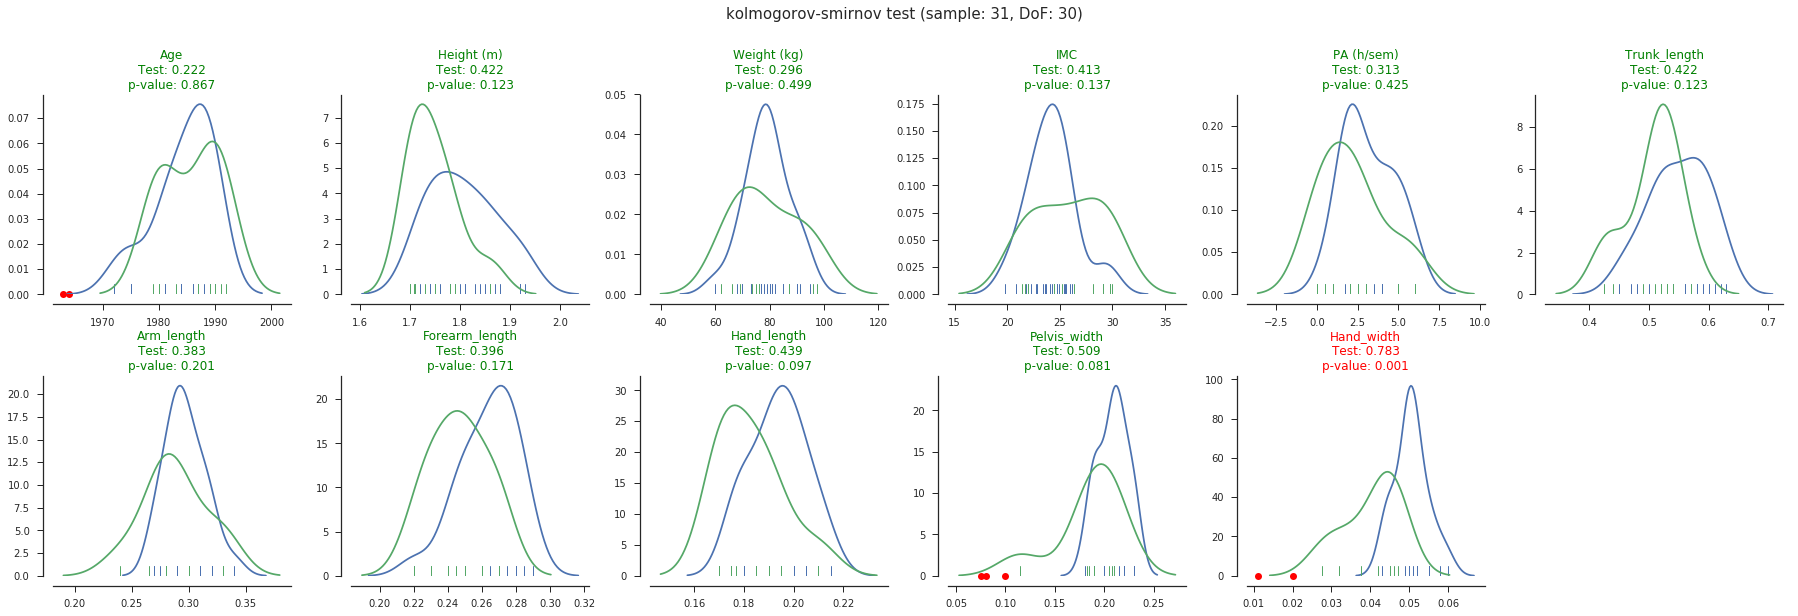

In [8]:
normality_test(df, case='kolmogorov-smirnov', group='Location', outliers_fct=is_outlier)

## Outcomes
- Removing the outliers allow to have equal distribution between Montréal and Lyon samples on the `Pelvis_width`

# Summary

## Normality tests (Shapiro-Wilk test)
- five variables are not normal: `Age`, `Height`, `PA`, `Pelvis_width` and `Hand_width`
- removing outliers did not change this result

## Are the france-canada groups homogeneous? (Kolmogorov-Smirnov test)
- two variables do not have an equivalent distribution between Montréal and Lyon samples: `Pelvis_width` and `Hand_width`
- removing outliers change this result on the `Pelvis_width`